# Import Statements-

In [1]:
from google.colab import drive 
drive.mount('/gdrive')
%cd /gdrive/My\ Drive/{'data'}

Mounted at /gdrive
/gdrive/My Drive/data


In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense,Input,Dropout,Flatten
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.utils import shuffle

# Loading and preprocessing the raw data to a .csv file-

In [3]:
# The data is given in the form of .txt files. Here we convert the data into a .csv file 
# and save it under the 'train' and 'test' directories for further use. Also the data here is 
# arranged according to the subject ID. Therefore to break any correlation that may exists 
# between the datapoints, we shuffle the dataset before dividing it into public and private 
# datasets to be used in the Neural Network model.
train_df = pd.read_csv('train.csv', header=0)
train_df.head()

,subject,acc1_x,acc1_y,acc1_z,gyro1_x,gyro1_y,gyro1_z,acc2_x,acc2_y,acc2_z,label
0,3,-0.049573,0.051482,0.061498,0.357428,0.876525,-1.077288,0.951736,-0.303094,-0.133766,5
1,3,-0.085298,0.048648,0.083263,0.337020,0.840771,-1.329607,0.918129,-0.301953,-0.111281,5
2,3,-0.046568,0.057793,0.114970,0.320000,0.909147,-0.788201,0.958863,-0.288855,-0.078756,5
3,3,0.001564,0.068723,0.144465,0.308596,0.773221,-0.313850,1.008886,-0.274002,-0.048346,5
4,3,-0.026644,0.088834,0.188589,0.308176,0.691534,-0.457948,0.982454,-0.250003,-0.003217,5


In [4]:
test_df = pd.read_csv('train.csv', header=0)
test_df.head()

,subject,acc1_x,acc1_y,acc1_z,gyro1_x,gyro1_y,gyro1_z,acc2_x,acc2_y,acc2_z,label
0,3,-0.049573,0.051482,0.061498,0.357428,0.876525,-1.077288,0.951736,-0.303094,-0.133766,5
1,3,-0.085298,0.048648,0.083263,0.337020,0.840771,-1.329607,0.918129,-0.301953,-0.111281,5
2,3,-0.046568,0.057793,0.114970,0.320000,0.909147,-0.788201,0.958863,-0.288855,-0.078756,5
3,3,0.001564,0.068723,0.144465,0.308596,0.773221,-0.313850,1.008886,-0.274002,-0.048346,5
4,3,-0.026644,0.088834,0.188589,0.308176,0.691534,-0.457948,0.982454,-0.250003,-0.003217,5


In [5]:
def create_dataset(X, y, time_steps=1, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        v = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        Xs.append(v)
        ys.append(stats.mode(labels)[0][0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

# Loading the data from the .csv file-

In [6]:
y_train = train_df['label']
X_train = train_df.drop(['label','subject'],axis=1)
y_test = test_df['label']
X_test = test_df.drop(['label','subject'],axis=1)

In [7]:
TIME_STEPS = 200
STEP = 40
from scipy import stats
X_train, y_train = create_dataset(X_train,y_train,TIME_STEPS,STEP)

X_test, y_test = create_dataset(X_test,y_test,TIME_STEPS,STEP)

In [8]:
print(X_train.shape, y_train.shape)

(13202, 200, 9) (13202, 1)


# Visualizing the data-

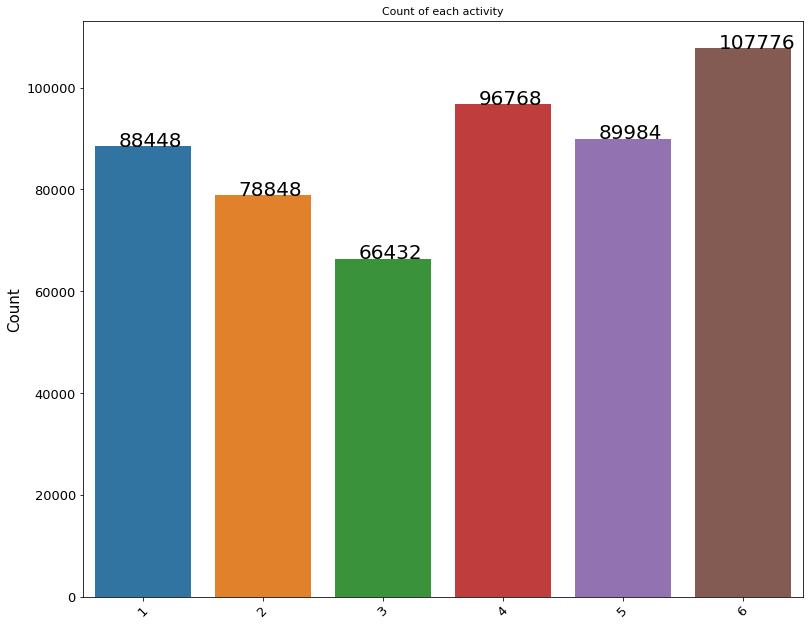

In [9]:
fig = plt.figure(figsize = (10,8))
ax = fig.add_axes([0,0,1,1])
ax.set_title("Count of each activity", fontsize = 11)
plt.tick_params(labelsize = 10)
sns.countplot(x='label' , data = train_df)
for i in ax.patches:
    ax.text(x = i.get_x() + 0.2 , y = i.get_height() + 10, s = str(i.get_height()), fontsize=20)
plt.xlabel('')
plt.ylabel('Count',fontsize =15)
plt.tick_params(labelsize = 13)
plt.xticks(rotation = 45)
plt.show()

# Global variables and Function declarations-

In [43]:
# Variables-
epochs = 25
batch_size = 32
num_classes = 6
fig_size = (9,7)

In [95]:
# FUNCTIONS-
import keras
from keras import layers
def PREPROCESS(X , y):
    X = np.array(X)
    y = np.array(y)
    return X,y

def CREATE_MODEL():
    model = keras.Sequential()
    model.add(keras.layers.LSTM(units=30,input_shape=[X_train.shape[1], X_train.shape[2]]))
    model.add(keras.layers.Dropout(rate=0.2))
    model.add(keras.layers.Dense(y_train.shape[1], activation='softmax'))
    model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])
    return model
    
def FIT(model,X,y,i):
    history = model.fit(
    X,
    y,
    validation_split=0.2,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint(f'./model_{i}.h5', save_best_only=True),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.1,
            patience=1
        )
    ],
    verbose=0
    )
    return history,model

def PLOT(history,i):
    epochs_range = range(epochs)
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    plt.figure(figsize=fig_size)
    plt.plot(epochs_range,train_loss,label="Training Loss")
    plt.plot(epochs_range,val_loss,label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title(f"Model {i} - Loss Over Time")
    plt.show()
    
    plt.figure(figsize=fig_size)
    plt.plot(epochs_range,train_acc,label="Training accuracy")
    plt.plot(epochs_range,val_acc,label="Validation accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("accuracy")
    plt.legend()
    plt.title(f"Model {i} - Accuracy")
    plt.show()

def CONFUSION_MATRIX(y_test, y_pred):
    confusionMatrix = confusion_matrix(y_test, y_pred)
    sns.set(font_scale=1.5)
    labels = ["WALKING", "WALKING_UPSTAIRS", "WALKING_DOWNSTAIRS", "SITTING", "STANDING", "LYING"]
    plt.figure(figsize=(16,7))
    sns.heatmap(confusionMatrix, cmap = "Blues", annot = True, fmt = ".0f", xticklabels=labels, yticklabels=labels)
    plt.title("Global Model Confusion Matrix", fontsize = 30)
    plt.xlabel('Predicted Class', fontsize = 20)
    plt.ylabel('Original Class', fontsize = 20)
    plt.tick_params(labelsize = 15)
    plt.xticks(rotation = 45)
    plt.show()
    
def LOAD_MODELS():
    for i in range(1,3):
        model = load_model(f'./model_{i}.h5')
        all_models.append(model)
def APPLY_WEIGHT_FUNCTION(weights):
    avg_model_weights = []
    n_models = len(all_models)
    n_layers = len(all_models[0].get_weights())
    for layer in range(n_layers):
        layer_weights = np.array([model.get_weights()[layer] for model in all_models])
        avg_layer_weights = np.average(layer_weights, axis=0, weights=weights)
        avg_model_weights.append(avg_layer_weights)
    return avg_model_weights;

# Model replica number-1 

In [96]:
# MODEL REPLICA NO.1
X_train_1 = X_train[0:6000]
y_train_1 = y_train[0:6000]

In [97]:
X_train_1, y_train_1 = PREPROCESS(X_train_1,y_train_1);

In [98]:
model_1 = CREATE_MODEL();
model_1.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 30)                4800      
_________________________________________________________________
dropout_12 (Dropout)         (None, 30)                0         
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 31        
Total params: 4,831
Trainable params: 4,831
Non-trainable params: 0
_________________________________________________________________


In [99]:
history_1,model_1 = FIT(model_1,X_train_1,y_train_1,1)

In [100]:
model_1.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 30)                4800      
_________________________________________________________________
dropout_12 (Dropout)         (None, 30)                0         
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 31        
Total params: 4,831
Trainable params: 4,831
Non-trainable params: 0
_________________________________________________________________


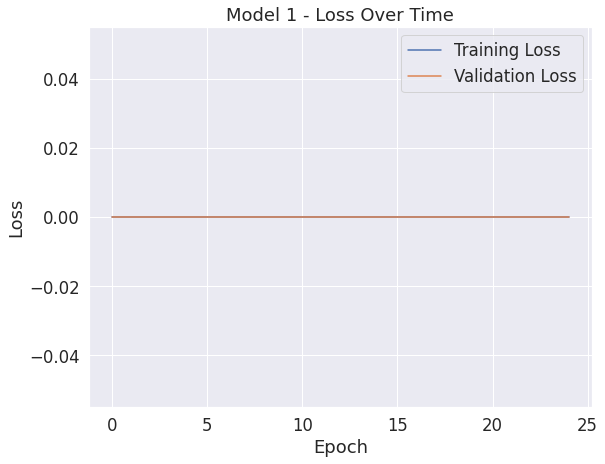

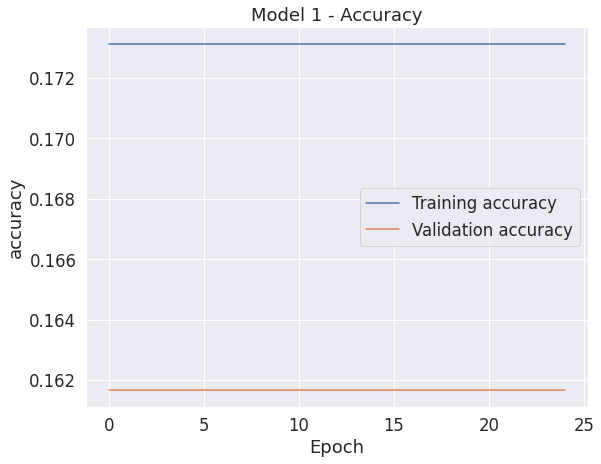

In [101]:
PLOT(history_1,1)

# Model replica number-2

In [102]:
# MODEL REPLICA NO.2
X_train_2 = X_train[6000:-1]
y_train_2 = y_train[6000:-1]

In [103]:
X_train_2, y_train_2 = PREPROCESS(X_train_2,y_train_2)

In [104]:
model_2 = CREATE_MODEL()
model_2.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 30)                4800      
_________________________________________________________________
dropout_13 (Dropout)         (None, 30)                0         
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 31        
Total params: 4,831
Trainable params: 4,831
Non-trainable params: 0
_________________________________________________________________


In [105]:

history_2,model_2 = FIT(model_2,X_train_2,y_train_2,2);

In [80]:
model_2.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 198, 20)           560       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 66, 20)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 64, 20)            1220      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 20)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 21        
Total params: 1,801
Trainable params: 1,801
Non-trainable params: 0
_________________________________________________________________


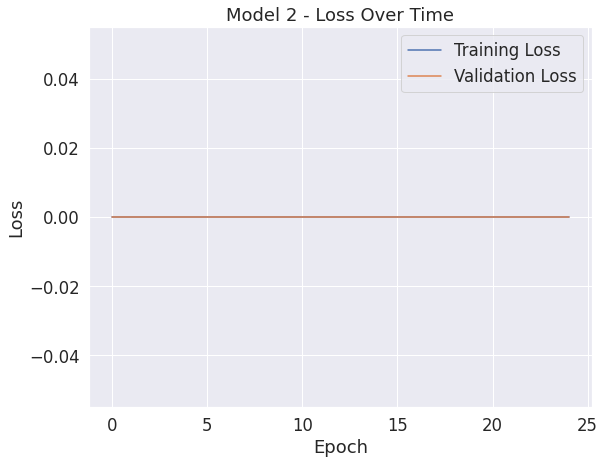

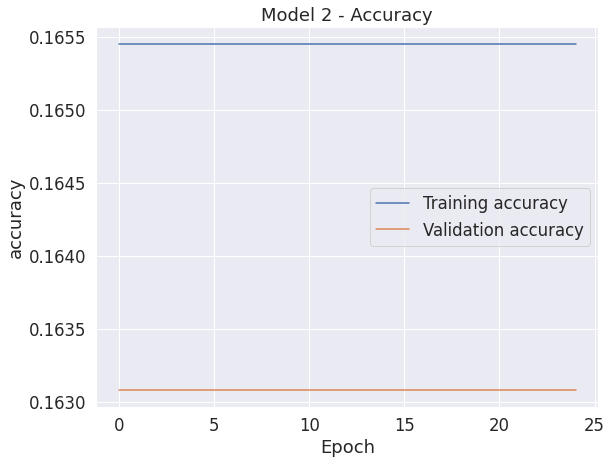

In [81]:
PLOT(history_2,2);

# Model replica number-3

In [65]:
# MODEL REPLICA NO.3
X_train_3 = X_train[36000:-1]
y_train_3 = y_train[36000:-1]

In [66]:
X_train_3, y_train_3 = PREPROCESS(X_train_3,y_train_3)

In [67]:
model_3 = CREATE_MODEL(X_train_3.shape[1])
model_3.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 256)               2560      
_________________________________________________________________
dropout_18 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_31 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_19 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_20 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_33 (Dense)             (None, 32)               

In [68]:
model_3 = COMPILE(model_3);
history_3, model_3 = FIT(model_3,X_train_3,y_train_3,3)

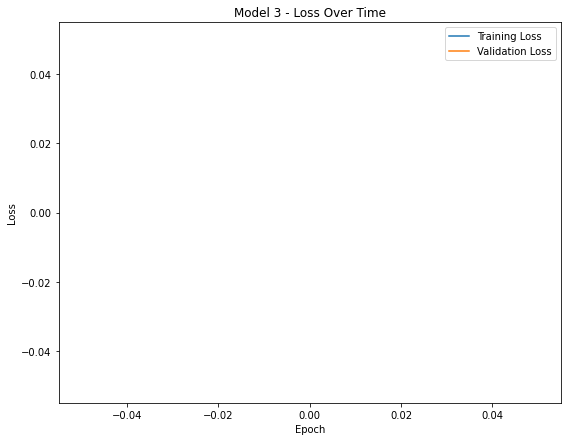

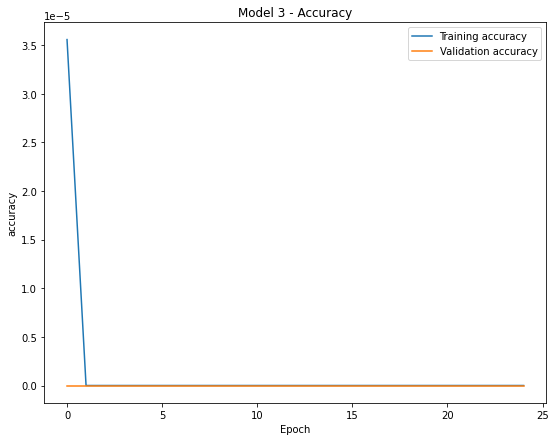

In [69]:
PLOT(history_3,3)

# The global model

In [106]:
X_test, y_test = PREPROCESS(X_test, y_test)

In [107]:
model_g = CREATE_MODEL()
model_g.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_14 (LSTM)               (None, 30)                4800      
_________________________________________________________________
dropout_14 (Dropout)         (None, 30)                0         
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 31        
Total params: 4,831
Trainable params: 4,831
Non-trainable params: 0
_________________________________________________________________


In [108]:
all_models = []
LOAD_MODELS()

In [85]:
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 

In [109]:
weights = [max(history_1.history['accuracy']), max(history_2.history['accuracy'])]
x = max(weights)
idx = weights.index(x)
weights[idx] = 1
x = min(weights)
idx = weights.index(x)
weights[idx] = 0.02
for i in range(2):
    if(weights[i] != 1 and weights[i] != 0.02):
        weights[i] = 0.03
        break
avg_model_weights = APPLY_WEIGHT_FUNCTION(weights)

In [110]:
model_g.set_weights(avg_model_weights)
_ , accuracy = model_g.evaluate(X_test,y_test,verbose=0)
print(f"Global Model Accuracy: {round(accuracy*100,2)}%")

Global Model Accuracy: 16.76%


In [67]:
y_pred = model_g.predict(X_test)
y_pred = np.argmax(y_pred,axis=1)

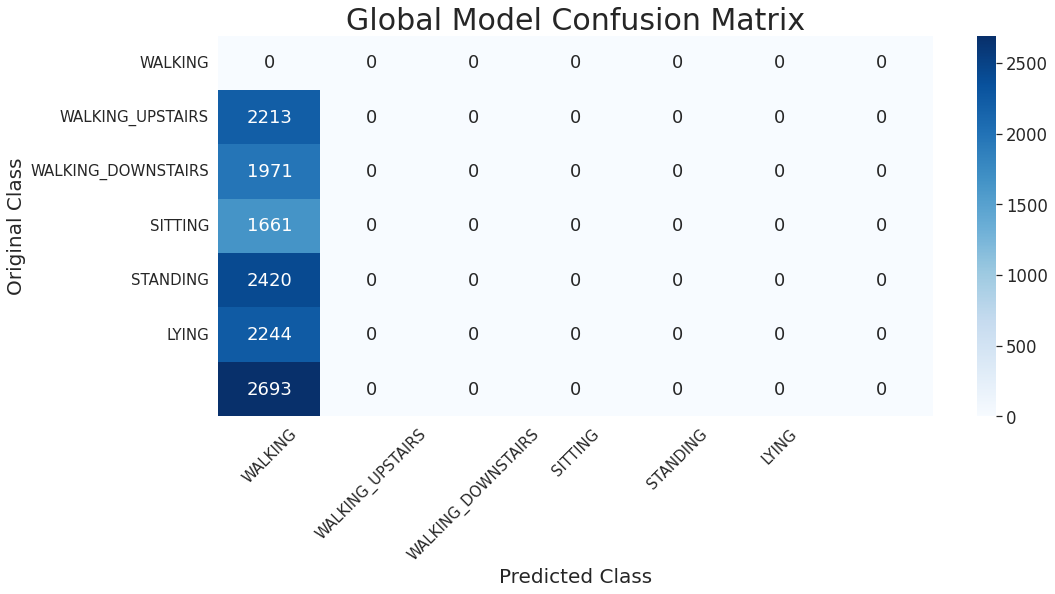

In [68]:
CONFUSION_MATRIX(y_test,y_pred)